# Weathering the Rails: The Impact of Extreme Temperatures and Temperature Changes on Railroad Safety
**Author:** Nathan Schaaf<br>
**Date:** December 10, 2024<br>
**Course:** Advanced Business Analytics, The Univerisity of North Carolina at Charlotte<br>
**Professional Context:** Prepared for the U.S. Railroad Industry (with focus on safety improvements)

## Table of Contents
1. [Introduction](##Introduction)
2. [Data Loading and Exploration](##Data-Loading-and-Exploration)
3. [Data Cleaning and Preprocessing](##Data-Cleaning-and-Preprocessing)
4. [Exploratory Data Analysis (EDA)](##Exploratory-Data-Analysis)
5. [Modeling and Results](##Modeling-and-Results)
6. [Conclusion](##Conclusion)
7. [References](##References)

## Introduction

<p>This analysis leverages advanced analytical techniques to predict potential derailment locations across the U.S. railroad industry, specifically focusing on track-related failures caused by extreme temperatures and daily temperature fluctuations. By integrating national weather forecast data with historical rail incident records, this analysis will identify high-risk areas most vulnerable to temperature-related impacts. The goal is to provide rail companies with actionable, data-driven insights that support the implementation of proactive maintenance strategies. These strategies will prioritize targeted track inspections and repairs, particularly during or after extreme weather events, to improve safety and reduce the risk of costly derailments.</p>
<p>Over the past decade, the U.S. rail network has experienced 4,595 incidents attributed to track failures, with 4,301 of these resulting in derailments. The average cost of a track failure incident is $208,356, with some incidents exceeding costs of $22 million. This analysis is especially critical as climate change intensifies unpredictable and extreme weather patterns. By identifying high-risk derailment locations, rail companies can proactively target maintenance efforts, reducing accidents, safeguarding human health and the environment, preserving infrastructure, and minimizing operational costs related to emergency response, cleanup, and repairs.</p>

### Key Takeaways

<ul>
<li><strong>Continue Current Track Maintneance Best Practices</strong></li>
<li><strong>Enhanced or More Frequent Track Inspections:</strong></li>
<ul>
<li><strong>Areas with Significant Temperature Fluctuations</strong></li>
<li><strong>High-Risk Cities</strong></li>
<li><strong>High-Risk Rail Routes</strong></li>
</ul>
</ul>

## Data Loading and Exploration

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from primaryAccidentCodesLibrary import primary_accident_cause_codes 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder

import scipy.stats as stats
from scipy.stats import chi2_contingency

import folium
from geopy.geocoders import Nominatim

from IPython.display import Image

### The Dataset
<p>The dataset is available in the git repository and directly referenced here.</p>

In [3]:
file_path = "https://raw.githubusercontent.com/NRSchaaf/Railroad_Accidents/refs/heads/main/railroad_incidents_temp_data_10yrs.csv"
accident_data = pd.read_csv(file_path)

<p>The <em>railroad_incidents_temp_data_10yrs.csv</em> data set is a combination of data pulled from the Federal Railroad Administration's (FRA) API for Safety Incident Reports and corresponding local weather data for each incident pulled from Visual Crossing Weather API.</p>
<p>The FRA data was pulled in two filtered groups, then recombined later for this analysis. This was done intentionally to allow other classmates to explore different aspects of this data set.</p>
<p>The FRA data was pulled using the <em>fra_data_pull.ipynb</em> notebook. This notebook was modified a few times for various data pulls. An important concepts here is that it filters for the past 10 years (2014 - 2024).</p>
<p>The incident associated location temperatures were pulled from Visual Crossings Weather API using the <em>weather_data_extraction.ipynb</em> notebook. This notebook was altered a few times to accomodate different incident data and different output storage files. It is important to note that only 1000 API calls are allowed daily using the free-tier subscription. Since each incident makes three API calls, it took numerous days to pull the data.</p>

In [57]:
accident_data.shape

(24572, 29)

There are 29 features (or columns) and 24,572 rows of information.

In [4]:
accident_data.head()

,reportingrailroadcode,accidentnumber,date,time,accidenttype,hazmatreleasedcars,station,stateabbr,temperature,visibility_code,...,trainspeed,equipmentdamagecost,trackdamagecost,totaldamagecost,primaryaccidentcausecode,latitude,longitude,prior_temp,actual_temp,following_temp
0,NS,154109,2023-09-04,4:00 AM,Side collision,0,ST LOUIS,MO,74,1.0,...,8,6976,0,20928,H702,38.698473,-90.223316,82.6,78.5,82.2
1,NS,154109,2023-09-04,4:00 AM,Side collision,0,ST LOUIS,MO,74,1.0,...,9,6976,6976,20928,H702,38.698473,-90.223316,82.6,78.5,82.2
2,CSX,000197605,2021-05-12,5:53 PM,Obstruction,0,ABBEVILLE,SC,49,3.0,...,35,20588,0,20588,M404,34.139719,-82.288592,66.4,54.4,54.7
3,BAYL,BAY687415,2015-04-19,11:00 AM,Derailment,0,ABBEVILLE,AL,75,2.0,...,0,24000,0,24000,M102,31.511825,-85.305147,67.6,70.4,70.5
4,CSX,000183279,2019-05-30,8:50 PM,Derailment,0,ABBEVILLE,SC,74,4.0,...,19,733124,77285,810409,T105,34.153089,-82.439475,81.4,80.8,80.3


The top 5 rows are displayed above in no sorted order.

## Data Cleaning and Preprocessing

In [5]:
accident_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24572 entries, 0 to 24571
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   reportingrailroadcode     24572 non-null  object 
 1   accidentnumber            24572 non-null  object 
 2   date                      24572 non-null  object 
 3   time                      24572 non-null  object 
 4   accidenttype              24570 non-null  object 
 5   hazmatreleasedcars        24572 non-null  int64  
 6   station                   24571 non-null  object 
 7   stateabbr                 24571 non-null  object 
 8   temperature               24572 non-null  int64  
 9   visibility_code           24566 non-null  float64
 10  visibility                24566 non-null  object 
 11  weathercondition          24569 non-null  object 
 12  tracktype                 24571 non-null  object 
 13  equipmenttype             23238 non-null  object 
 14  trains

There are 12 numeric and 12 categorical features in this dataset.

In [6]:
# Count missing values in each column
missing_values = accident_data.isnull().sum()

missing_values

reportingrailroadcode          0
accidentnumber                 0
date                           0
time                           0
accidenttype                   2
hazmatreleasedcars             0
station                        1
stateabbr                      1
temperature                    0
visibility_code                6
visibility                     6
weathercondition               3
tracktype                      1
equipmenttype               1334
trainspeed                     0
equipmentdamagecost            0
trackdamagecost                0
totaldamagecost                0
primaryaccidentcausecode       2
latitude                       0
longitude                      0
prior_temp                     0
actual_temp                    0
following_temp                 0
dtype: int64

9 features have missing information. Since most of these features are missing a few quantity of values, we will drop these rows without statitically impacting our analysis.

In [7]:
# Specify the columns to check for missing values
columns_to_check = ['accidenttype', 'station', 'visibility_code', 'weathercondition', 'tracktype', 'primaryaccidentcausecode']

# Drop rows with missing values in the specified columns
accident_data_dropMissing = accident_data.dropna(subset=columns_to_check).copy()

# Count missing values in each column
missing_values2 = accident_data_dropMissing.isnull().sum()

missing_values2

reportingrailroadcode          0
accidentnumber                 0
date                           0
time                           0
accidenttype                   0
hazmatreleasedcars             0
station                        0
stateabbr                      0
temperature                    0
visibility_code                0
visibility                     0
weathercondition               0
tracktype                      0
equipmenttype               1331
trainspeed                     0
equipmentdamagecost            0
trackdamagecost                0
totaldamagecost                0
primaryaccidentcausecode       0
latitude                       0
longitude                      0
prior_temp                     0
actual_temp                    0
following_temp                 0
dtype: int64

We are left with a signficant quantity of missing values in the 'equipmenttype' feature. This feature is included in the analysis as it might be of interest to the business, but will likely have no impact on the temperature target analysis. So, we will impute the missing values using a Random Forest model. We impute the missing values to avoid modeling issues in the future.

In [8]:
# Split data into rows with and without missing 'equipmenttype'
data_with_equiptype = accident_data_dropMissing.dropna(subset=['equipmenttype']).copy()
data_missing_equiptype = accident_data_dropMissing[accident_data_dropMissing['equipmenttype'].isna()].copy()

# Features and target
features = ['accidenttype', 'station', 'visibility_code', 'weathercondition', 'tracktype', 'primaryaccidentcausecode']
target = 'equipmenttype'

# One-Hot Encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(data_with_equiptype[features])
X_missing_encoded = encoder.transform(data_missing_equiptype[features])

# Encode target variable as numeric
data_with_equiptype['equipmenttype_numeric'], equiptype_classes = pd.factorize(data_with_equiptype[target])

# Split non-missing data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, data_with_equiptype['equipmenttype_numeric'], test_size=0.2, random_state=42
)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Evaluation Metrics:")
print(classification_report(y_test, y_pred, target_names=equiptype_classes))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Predict missing equipmenttype
predicted_numeric = rf_model.predict(X_missing_encoded)
data_missing_equiptype['equipmenttype'] = [equiptype_classes[i] for i in predicted_numeric]

# Impute missing values in the original dataset
accident_data_dropMissing.loc[data_missing_equiptype.index, 'equipmenttype'] = data_missing_equiptype['equipmenttype']

Evaluation Metrics:
                           precision    recall  f1-score   support

           Yard/switching       0.49      0.57      0.53      1306
            Freight Train       0.67      0.77      0.71      1975
              Cut of cars       0.21      0.14      0.17       303
         Spec. MoW Equip.       0.65      0.61      0.63        80
Passenger Train - Pulling       0.56      0.34      0.42       182
Passenger Train - Pushing       0.50      0.03      0.06        30
            Light loco(s)       0.22      0.10      0.14       223
               Single Car       0.47      0.38      0.42       332
       Maint./inspect Car       0.44      0.24      0.31        33
               Work train       0.00      0.00      0.00        23
 Commuter Train - Pulling       0.00      0.00      0.00        21
                      EMU       0.64      0.40      0.49        92
 Commuter Train - Pushing       0.25      0.03      0.05        38
                      DMU       1.00     

Although the accuracy of imputation using this model is only 56%, it is not of relevant concern since this feature will not be used in the temperature analysis. Should the business choose to explore the relationship between temperature and equipment type later, then this imputation should be revisited. 

In [9]:
# Count missing values in each column
missing_values3 = accident_data_dropMissing.isnull().sum()

missing_values3

reportingrailroadcode       0
accidentnumber              0
date                        0
time                        0
accidenttype                0
hazmatreleasedcars          0
station                     0
stateabbr                   0
temperature                 0
visibility_code             0
visibility                  0
weathercondition            0
tracktype                   0
equipmenttype               0
trainspeed                  0
equipmentdamagecost         0
trackdamagecost             0
totaldamagecost             0
primaryaccidentcausecode    0
latitude                    0
longitude                   0
prior_temp                  0
actual_temp                 0
following_temp              0
dtype: int64

This verifies that all missing values have been addressed.

### Feature Engineering
In order to evaluate temperature change, we must create the necessary features and calculate the appropriate values.

In [11]:
accident_data_temps = accident_data_dropMissing.copy()

# Create new features based on temperature changes in the new dataframe
accident_data_temps['before_temp_change'] = accident_data_temps['actual_temp'] - accident_data_temps['prior_temp']
accident_data_temps['after_temp_change'] = accident_data_temps['following_temp'] - accident_data_temps['actual_temp']
accident_data_temps['across_temp_change'] = accident_data_temps['following_temp'] - accident_data_temps['prior_temp']

# Show the first few rows to verify the new dataframe
accident_data_temps[['before_temp_change', 'after_temp_change', 'across_temp_change']].head()

,before_temp_change,after_temp_change,across_temp_change
0,-4.1,3.7,-0.4
1,-4.1,3.7,-0.4
2,-12.0,0.3,-11.7
3,2.8,0.1,2.9
4,-0.6,-0.5,-1.1


<p>We have created 3 features based on daily averages:<br>
<ul>
<li><strong>before_temp_change</strong>: represents the temperature change leading up to the incident</li>
<li><strong>after_temp_change</strong>: represents the temperature shift immediately after the incident</li>
<li><strong>across_temp_change</strong>: captures the overall temperature variability around the incident</li>
</ul></p>
<p>We did not explore the daily max and min temperatures. Further analysis into such variance might yeild actionable insights.</p>

### Basic Statistics

In [14]:
accident_data_temps.describe().T

,count,mean,std,min,25%,50%,75%,max
hazmatreleasedcars,24564.0,0.013679,0.315397,0.00000,0.000000,0.000000,0.000000,2.800000e+01
temperature,24564.0,59.484001,21.524710,-36.00000,44.000000,62.000000,75.000000,1.150000e+02
visibility_code,24564.0,2.686289,1.061220,1.00000,2.000000,2.000000,4.000000,4.000000e+00
trainspeed,24564.0,11.454364,16.772020,0.00000,3.000000,5.000000,10.000000,1.350000e+02
equipmentdamagecost,24564.0,83707.133814,422041.551285,0.00000,5000.000000,17000.000000,45000.000000,2.714000e+07
trackdamagecost,24564.0,42830.834473,206166.186341,0.00000,0.000000,1750.000000,19201.750000,1.040000e+07
totaldamagecost,24564.0,159077.917196,654785.585706,0.00000,19095.000000,36847.500000,97333.250000,3.153875e+07
latitude,24564.0,37.666360,5.089550,0.00000,33.649549,38.682012,41.294779,6.484530e+01
longitude,24564.0,-92.659629,13.737429,-683.19219,-97.670749,-90.384649,-83.554021,0.000000e+00
prior_temp,24564.0,58.547851,18.887286,-16.80000,44.600000,61.300000,74.300000,1.015000e+02


The basic statistics for numerical data is provided above for the entire dataset (all incident causes).

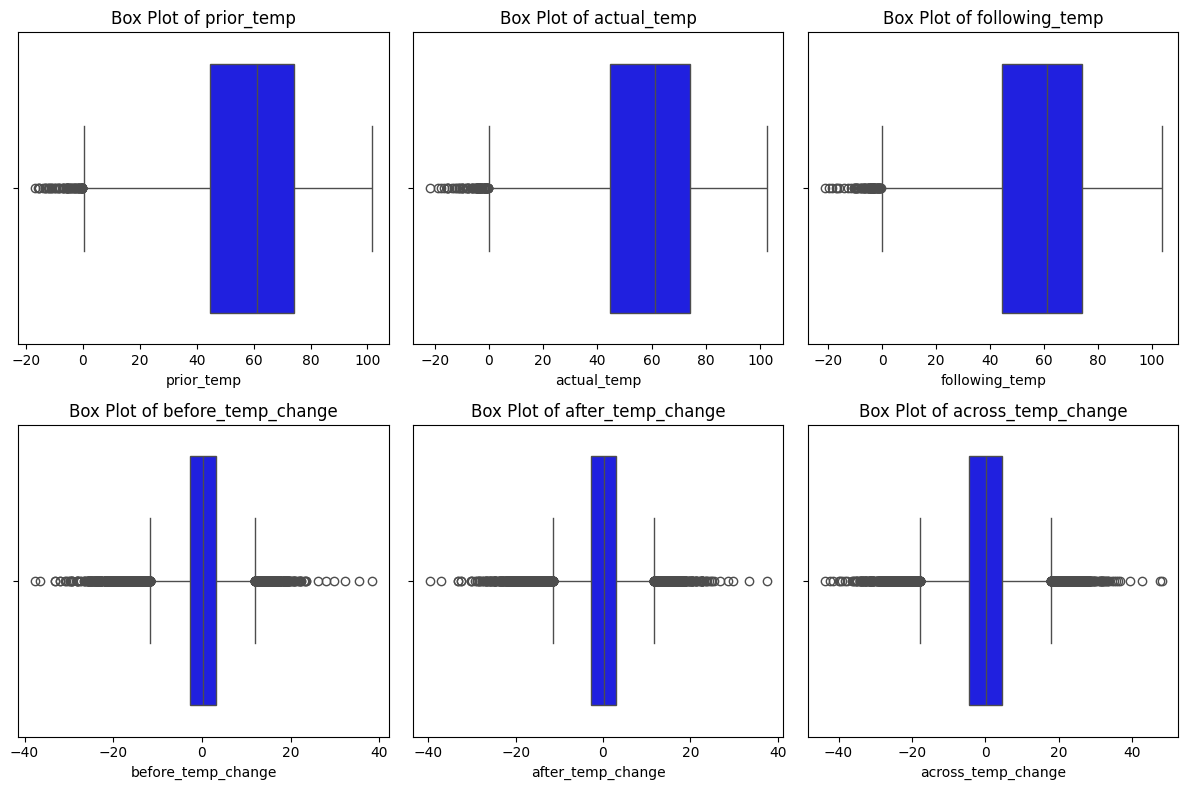

In [16]:
# Create a list of the columns to plot
columns_to_plot = ['prior_temp', 'actual_temp', 'following_temp', 'before_temp_change', 'after_temp_change', 'across_temp_change']

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create boxplots for each column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)  # Create a 2x3 grid of subplots
    sns.boxplot(x=accident_data_temps[column], color='blue')  # Customize color as needed
    plt.title(f'Box Plot of {column}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

<p>It is worth noting that most incidents occur when temperatures are between 40 and 80 degrees Farenheit, a "moderate" temperature range, as seen in the 1st row of Box Plots.</p>
<p>Because we are specifically looking at <strong>extreme</strong> temperatures and temperature changes, we do not disclude any outliers in this analysis.</p>

## Exploratory Data Analysis

### Track-Related Incident Types
How many incidents are track-related vs. other types?

Track-related incidents: 4595
Other incidents: 19977


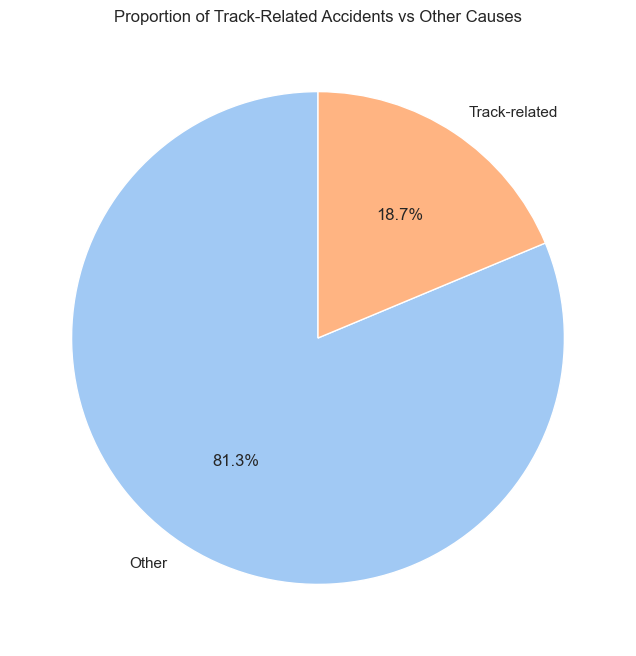

In [ ]:
# Categorize accidents
accident_data['accident_category'] = accident_data['primaryaccidentcausecode'].apply(
    lambda x: 'Track-related' if x in primary_accident_cause_codes else 'Other'
)

# Aggregate data
accident_counts = accident_data['accident_category'].value_counts()

# Print totals
print(f"Track-related incidents: {accident_counts.get('Track-related', 0)}")
print(f"Other incidents: {accident_counts.get('Other', 0)}")

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Plot pie chart
colors = sns.color_palette('pastel')  # Use a Seaborn color palette
plt.figure(figsize=(8, 8))
plt.pie(accident_counts, labels=accident_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Proportion of Track-Related Accidents vs Other Causes')
plt.show()

In the past decade, 4,595 (or 18.7%) of incidents have a track-related root cause.

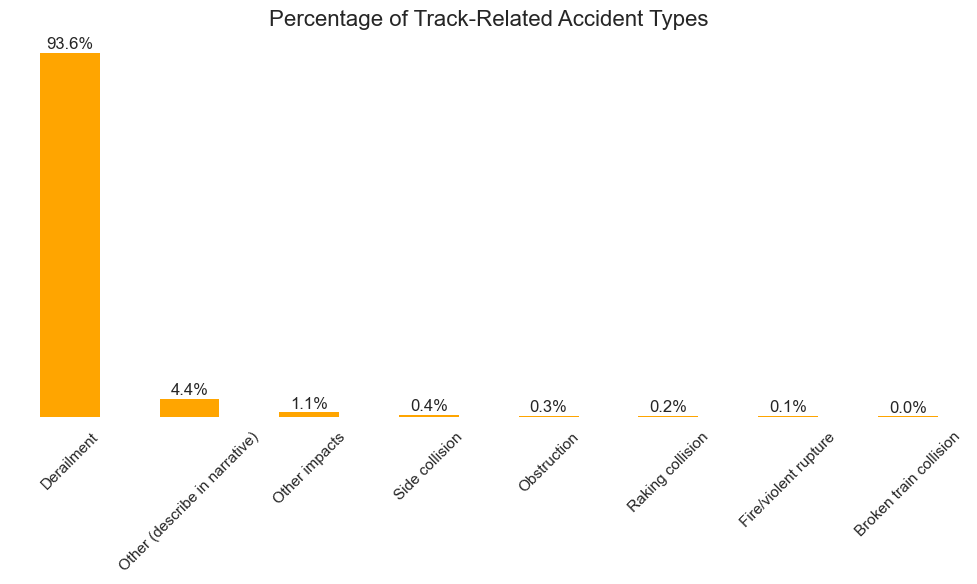

In [46]:
# How many track failures result in a derailment?

# Filter the accident data to only include track-related incidents
filtered_data = accident_data_temps[accident_data_temps['primaryaccidentcausecode'].isin(primary_accident_cause_codes)]

# Calculate the percentage of each 'accident_type'
accident_type_counts = filtered_data['accidenttype'].value_counts(normalize=True) * 100

# Create a column plot to show the percentage of each 'accident_type'
plt.figure(figsize=(10,6))
ax = accident_type_counts.plot(kind='bar', color='orange', edgecolor='none')  # Hide outline of bars
plt.title('Percentage of Track-Related Accident Types', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('')  # Remove Y-axis label
plt.xticks(rotation=45)

# Add the percentage value on top of each column
for i, v in enumerate(accident_type_counts):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=12)

# Remove the Y-axis
ax.yaxis.set_visible(False)

# Hide vertical gridlines
ax.grid(axis='y', linestyle='-', alpha=0.3)  # Horizontal gridlines are still visible
ax.grid(axis='x', visible=False)  # Hide vertical gridlines

# Remove the plot border by hiding spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

94% of these track-related incidents resulted in a derailment.

In [61]:
# Basic Stats of Track-Related Incidents

# Filter the data to only include track-related accidents
track_related_accidents = accident_data[accident_data['accident_category'] == 'Track-related']

# Get basic statistics for track-related accidents
track_related_accidents.describe().T


,count,mean,std,min,25%,50%,75%,max
hazmatreleasedcars,4595.0,0.028945,0.526021,0.00000,0.000000,0.000000,0.000000,2.800000e+01
temperature,4595.0,58.926877,22.587870,-35.00000,41.000000,60.000000,77.000000,1.150000e+02
visibility_code,4595.0,2.660936,1.035686,1.00000,2.000000,2.000000,4.000000,4.000000e+00
trainspeed,4595.0,9.551687,12.077753,0.00000,4.000000,6.000000,9.000000,1.250000e+02
equipmentdamagecost,4595.0,114259.902938,448682.514449,0.00000,5282.500000,19123.000000,63174.500000,2.194712e+07
trackdamagecost,4595.0,67180.249837,202218.147279,0.00000,1857.000000,12000.000000,47450.000000,4.600000e+06
totaldamagecost,4595.0,208355.717954,664294.973831,0.00000,20940.500000,48135.000000,144222.500000,2.201925e+07
latitude,4595.0,37.919532,5.213919,0.00000,33.741081,39.110705,41.412739,4.901675e+01
longitude,4595.0,-92.067926,15.604322,-683.19219,-97.353523,-90.605520,-83.505282,0.000000e+00
prior_temp,4595.0,57.591077,19.029285,-16.80000,42.150000,59.700000,74.100000,1.002000e+02


<p>Above are the basic statistics for track-related incidents.</p>
<p>It is worth noting that the average track-related incident cost is $208,356 with a maximum cost of over $22 million.</p>

### FRA Data Entry Accuracy for Incident Temperature
Since we have the data... What is the reporting accuracy for incident temperature?

C:\Users\natha\AppData\Local\Temp\ipykernel_38296\3861214363.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=accident_data, x='temp_diff_category_10', palette='Set2', ax=axes[0])
C:\Users\natha\AppData\Local\Temp\ipykernel_38296\3861214363.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=accident_data, x='temp_diff_category_5', palette='Set2', ax=axes[1])


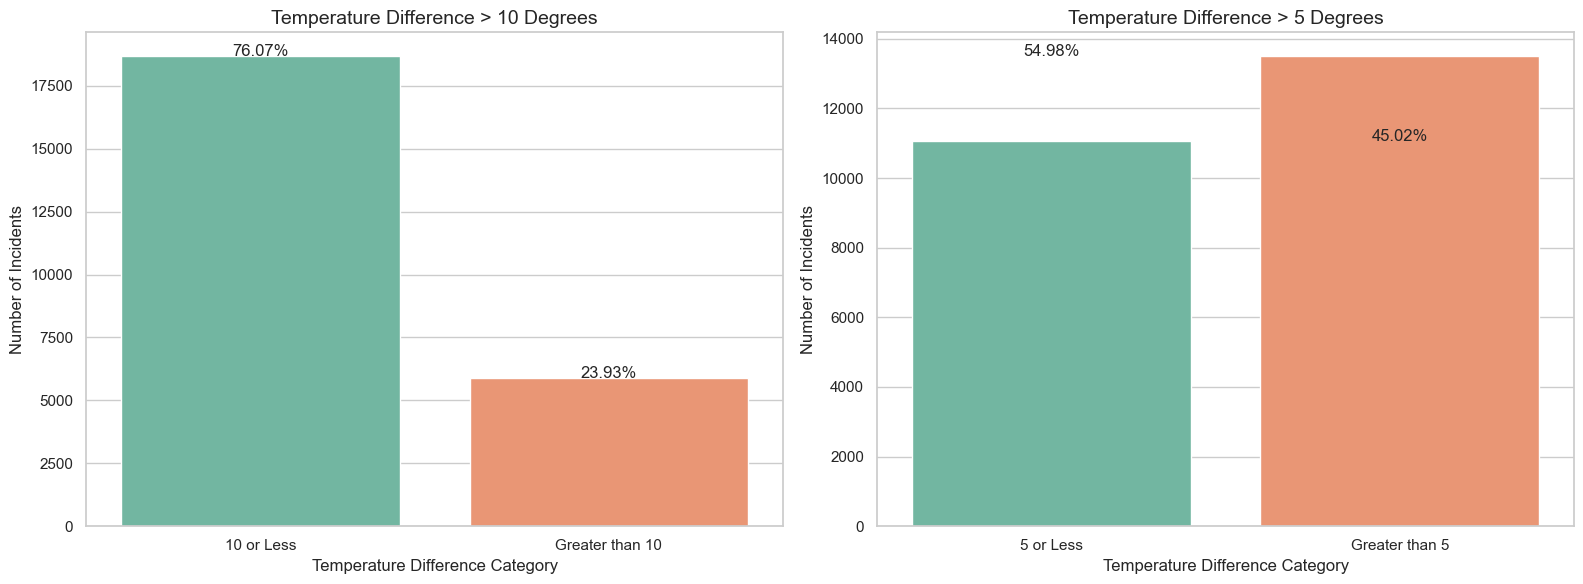

In [63]:
# Create a new column for temperature difference categorized by 10 degrees
accident_data['temp_diff_category_10'] = accident_data['temp_diff'].apply(
    lambda x: 'Greater than 10' if x > 10 else '10 or Less'
)

# Create a new column for temperature difference categorized by 5 degrees
accident_data['temp_diff_category_5'] = accident_data['temp_diff'].apply(
    lambda x: 'Greater than 5' if x > 5 else '5 or Less'
)

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first graph with a 10-degree variance
category_counts_10 = accident_data['temp_diff_category_10'].value_counts()
category_percentages_10 = (category_counts_10 / len(accident_data)) * 100

sns.countplot(data=accident_data, x='temp_diff_category_10', palette='Set2', ax=axes[0])
axes[0].set_title('Temperature Difference > 10 Degrees', fontsize=14)
axes[0].set_xlabel('Temperature Difference Category', fontsize=12)
axes[0].set_ylabel('Number of Incidents', fontsize=12)

# Add percentage labels to the first graph
for i, count in enumerate(category_counts_10):
    percentage = category_percentages_10.iloc[i]
    axes[0].text(i, count + 10, f'{percentage:.2f}%', ha='center', fontsize=12)

# Plot the second graph with a 5-degree variance
category_counts_5 = accident_data['temp_diff_category_5'].value_counts()
category_percentages_5 = (category_counts_5 / len(accident_data)) * 100

sns.countplot(data=accident_data, x='temp_diff_category_5', palette='Set2', ax=axes[1])
axes[1].set_title('Temperature Difference > 5 Degrees', fontsize=14)
axes[1].set_xlabel('Temperature Difference Category', fontsize=12)
axes[1].set_ylabel('Number of Incidents', fontsize=12)

# Add percentage labels to the second graph
for i, count in enumerate(category_counts_5):
    percentage = category_percentages_5.iloc[i]
    axes[1].text(i, count + 10, f'{percentage:.2f}%', ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

<p>FRA incident reports are manually submitted by each railroad, so the data accuracy will depend upon how each railroad collects its data. As of the time of this analysis, and at my industry awareness, most railroads manually imput the temperature information.</p>
<p>As you can see, 24% of reporting is off by 10 degrees and 45% of reporting is off by 5 degrees. This is impactful since a few degrees can make the differene between freezing and cold temperatures, as well as moderate and hot temperatures. This is also why we pulled temperature data from a weather history source, to avoid bias and error.</p>

## Modeling and Results

### Extreme Temperatures
<ul>
<li>Null Hypothesis (𝐻<sub>0</sub>): Extreme temperatures (<32˚F or >85˚F) do not have an impact on track incidents.
</li>
<li>Alternative Hypothesis (𝐻<sub>1</sub>): Extreme temperatures (<32˚F or >85˚F) do have an impact on track incidents.
</li>
</ul>

In [ ]:
df = accident_data_temps.copy()

# Ensure necessary columns exist
assert 'actual_temp' in df.columns and 'primaryaccidentcausecode' in df.columns

# Step 1: Classify Extreme Temperatures Separately
df['above_29_44'] = (df['actual_temp'] > 29.44).astype(int)
df['below_0'] = (df['actual_temp'] < 0).astype(int)

# Step 2: Identify Track-Related Incidents
df['track_related'] = df['primaryaccidentcausecode'].isin(primary_accident_cause_codes).astype(int)

# Step 3: Create Contingency Tables
contingency_above_29_44 = pd.crosstab(df['above_29_44'], df['track_related'])
contingency_below_0 = pd.crosstab(df['below_0'], df['track_related'])

# Step 4: Perform Chi-Square Tests
chi2_above, p_above, _, _ = chi2_contingency(contingency_above_29_44)
chi2_below, p_below, _, _ = chi2_contingency(contingency_below_0)

# Results
print("Results for Above 29.44°C:")
print(f"Chi2 Statistic: {chi2_above}")
print(f"P-value: {p_above}")

print("\nResults for Below 0°C:")
print(f"Chi2 Statistic: {chi2_below}")
print(f"P-value: {p_below}")

# Interpretation
if p_above < 0.05:
    print("\nAbove 29.44°C: Reject the null hypothesis; significant impact on track-related incidents.")
else:
    print("\nAbove 29.44°C: Fail to reject the null hypothesis; no significant impact on track-related incidents.")

if p_below < 0.05:
    print("Below 0°C: Reject the null hypothesis; significant impact on track-related incidents.")
else:
    print("Below 0°C: Fail to reject the null hypothesis; no significant impact on track-related incidents.")

Results for Above 29.44°C:
Chi2 Statistic: 1.2350363957151747
P-value: 0.2664298102041954

Results for Below 0°C:
Chi2 Statistic: 0.05665480871957236
P-value: 0.8118634831471219

Above 29.44°C: Fail to reject the null hypothesis; no significant impact on track-related incidents.
Below 0°C: Fail to reject the null hypothesis; no significant impact on track-related incidents.


<p>For both cases, below 32˚F and above 85˚F, we fail to reject the null hypothesis as these contains no significant statistical impact.</p>
<p>Therefore, extreme temperatures have no significant impact on track-related incident occurances.</p>

### Extreme Temperature Changes
<ul>
<li>Null Hypothesis (𝐻<sub>0</sub>): Temperature change does not have an impact on track incidents.</li>
<li>Alternative Hypothesis (𝐻<sub>1</sub>): Temperature change does have an impact on track incidents.</li>
</ul>

In [ ]:
# Convert 'primaryaccidentcausecode' to categorical labels if necessary (for track-related incidents vs others)
accident_data_temps['accident_category'] = accident_data_temps['primaryaccidentcausecode'].apply(
    lambda x: 'Track-related' if x in primary_accident_cause_codes else 'Other'
)

# Perform ANOVA for each temperature change feature
def perform_anova(temp_feature, df):
    track_related = df[df['accident_category'] == 'Track-related'][temp_feature]
    other = df[df['accident_category'] == 'Other'][temp_feature]
    
    f_stat, p_value = stats.f_oneway(track_related.dropna(), other.dropna())
    return f_stat, p_value

# Run ANOVA tests for each temperature change feature
anova_results = {
    'before_temp_change': perform_anova('before_temp_change', accident_data_temps),
    'after_temp_change': perform_anova('after_temp_change', accident_data_temps),
    'across_temp_change': perform_anova('across_temp_change', accident_data_temps),
}

# Print results
for temp_feature, (f_stat, p_value) in anova_results.items():
    print(f"ANOVA for {temp_feature}: F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}")
    
    # Interpretation
    if p_value < 0.05:
        print(f"Reject the null hypothesis: There is a significant difference for {temp_feature}.")
    else:
        print(f"Fail to reject the null hypothesis: There is no significant difference for {temp_feature}.")

ANOVA for before_temp_change: F-statistic = 2.754, p-value = 0.097
Fail to reject the null hypothesis: There is no significant difference for before_temp_change.
ANOVA for after_temp_change: F-statistic = 6.149, p-value = 0.013
Reject the null hypothesis: There is a significant difference for after_temp_change.
ANOVA for across_temp_change: F-statistic = 0.310, p-value = 0.578
Fail to reject the null hypothesis: There is no significant difference for across_temp_change.


<p>For the before_temp_change and across_temp_change cases, we fail to reject the null hypothesiss these contain no significant statistical impact.</p>
<p>However, we do reject the null hypothesis for after_temp_change as it does have a slight statistical significance with a p-value of 0.013. We can analyize this feature further to gain business insights.</p>

#### Critical Temperature Threshold
<p>What is the critical temperature threshold at which a railroad should act to reduce the likelihood of a track-related incident?</p>

In [49]:
# Flag rows where after_temp_change exceeds the threshold (positive or negative) for track-related incidents
accident_data_temps['accident_category'] = accident_data_temps['primaryaccidentcausecode'].apply(
    lambda x: 'Track-related' if x in primary_accident_cause_codes else 'Other'
)

# Filter for track-related incidents
track_related_data = accident_data_temps[accident_data_temps['accident_category'] == 'Track-related']

# Calculate the 90th percentile of after_temp_change for track-related incidents
threshold = track_related_data['after_temp_change'].quantile(0.90)
print(f"Critical temperature change threshold (90th percentile) for track-related incidents: {threshold}°C")

# Flag rows where after_temp_change exceeds the threshold (positive or negative) for track-related incidents
significant_changes = track_related_data[
    (track_related_data['after_temp_change'] > threshold) | 
    (track_related_data['after_temp_change'] < -threshold)
]

# Total number of track-related incidents in the dataset
total_track_incidents = track_related_data.shape[0]

# Display the count of track-related incidents and the number of significant temperature changes
print(f"Total number of track-related incidents: {total_track_incidents}")
print(f"Number of track-related incidents with significant temperature changes: {significant_changes.shape[0]}")


Critical temperature change threshold (90th percentile) for track-related incidents: 6.600000000000001°C
Total number of track-related incidents: 4595
Number of track-related incidents with significant temperature changes: 973


<p>A temperature change of 6.6°C is the 90th percentile threshold for track-related incidents. In other words, 90% of the track-related incidents involve temperature changes below this value, while only 10% involve temperature changes above it.</p>
<p>21% (973 of 4,595) of incidents in the past decade occured during such a temperature change.</p>

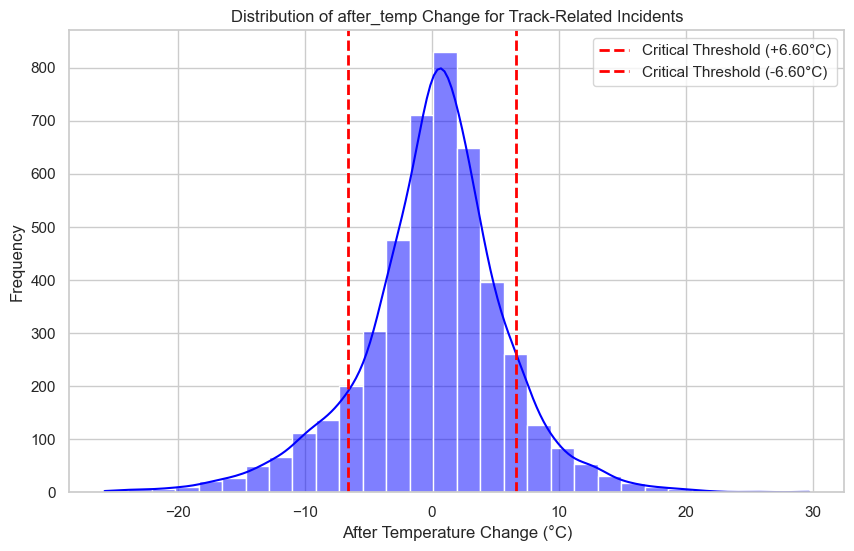

In [50]:
# Filter data for track-related incidents only
track_related_data = accident_data_temps[accident_data_temps['accident_category'] == 'Track-related']

# Plot the distribution of after_temp_change for track-related incidents
plt.figure(figsize=(10, 6))
sns.histplot(track_related_data['after_temp_change'], bins=30, kde=True, color='blue')

# Add vertical lines for both positive and negative critical thresholds
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f"Critical Threshold (+{threshold:.2f}°C)")
plt.axvline(-threshold, color='red', linestyle='dashed', linewidth=2, label=f"Critical Threshold (-{threshold:.2f}°C)")

# Add labels and legend
plt.title('Distribution of after_temp Change for Track-Related Incidents')
plt.xlabel('After Temperature Change (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

90% of track-related incidents occur when there is less than a 6.6°C temperature change. This makes sense when we consider that after_temp_change was only slightly statistically significant.

In [66]:
# Define the change in Celsius
change_celsius = 6.6

# Convert the change to Fahrenheit
change_fahrenheit = change_celsius * 9 / 5

# Print the result with the degree symbol
print(f"The result of a {change_celsius}°C change is {change_fahrenheit}°F")

The result of a 6.6°C change is 11.879999999999999°F


A 6°C temperature change is equivalent to an 12°F temperature change.

#### High-Risk Geographic Locations
Here we can utlize ESRI ARC GIS Online to provide a visualization for high-risk temperature impacted track-related incidents.

In [52]:
# Filter the data where after_temp_change is greater than or equal to 6.6 degrees Celsius
threshold = 6.6  # Temperature change threshold in Celsius
filtered_data = accident_data_temps[accident_data_temps['after_temp_change'] >= threshold]

# Export the filtered data to a CSV file for use in ESRI ArcGIS Online
filtered_data.to_csv('accidents_temp_change_mapping.csv', index=False)

print("Filtered data has been exported to 'accidents_temp_change_mapping.csv'")

Filtered data has been exported to 'accidents_temp_change_mapping.csv'


Export the data for upload into ARC GIS.

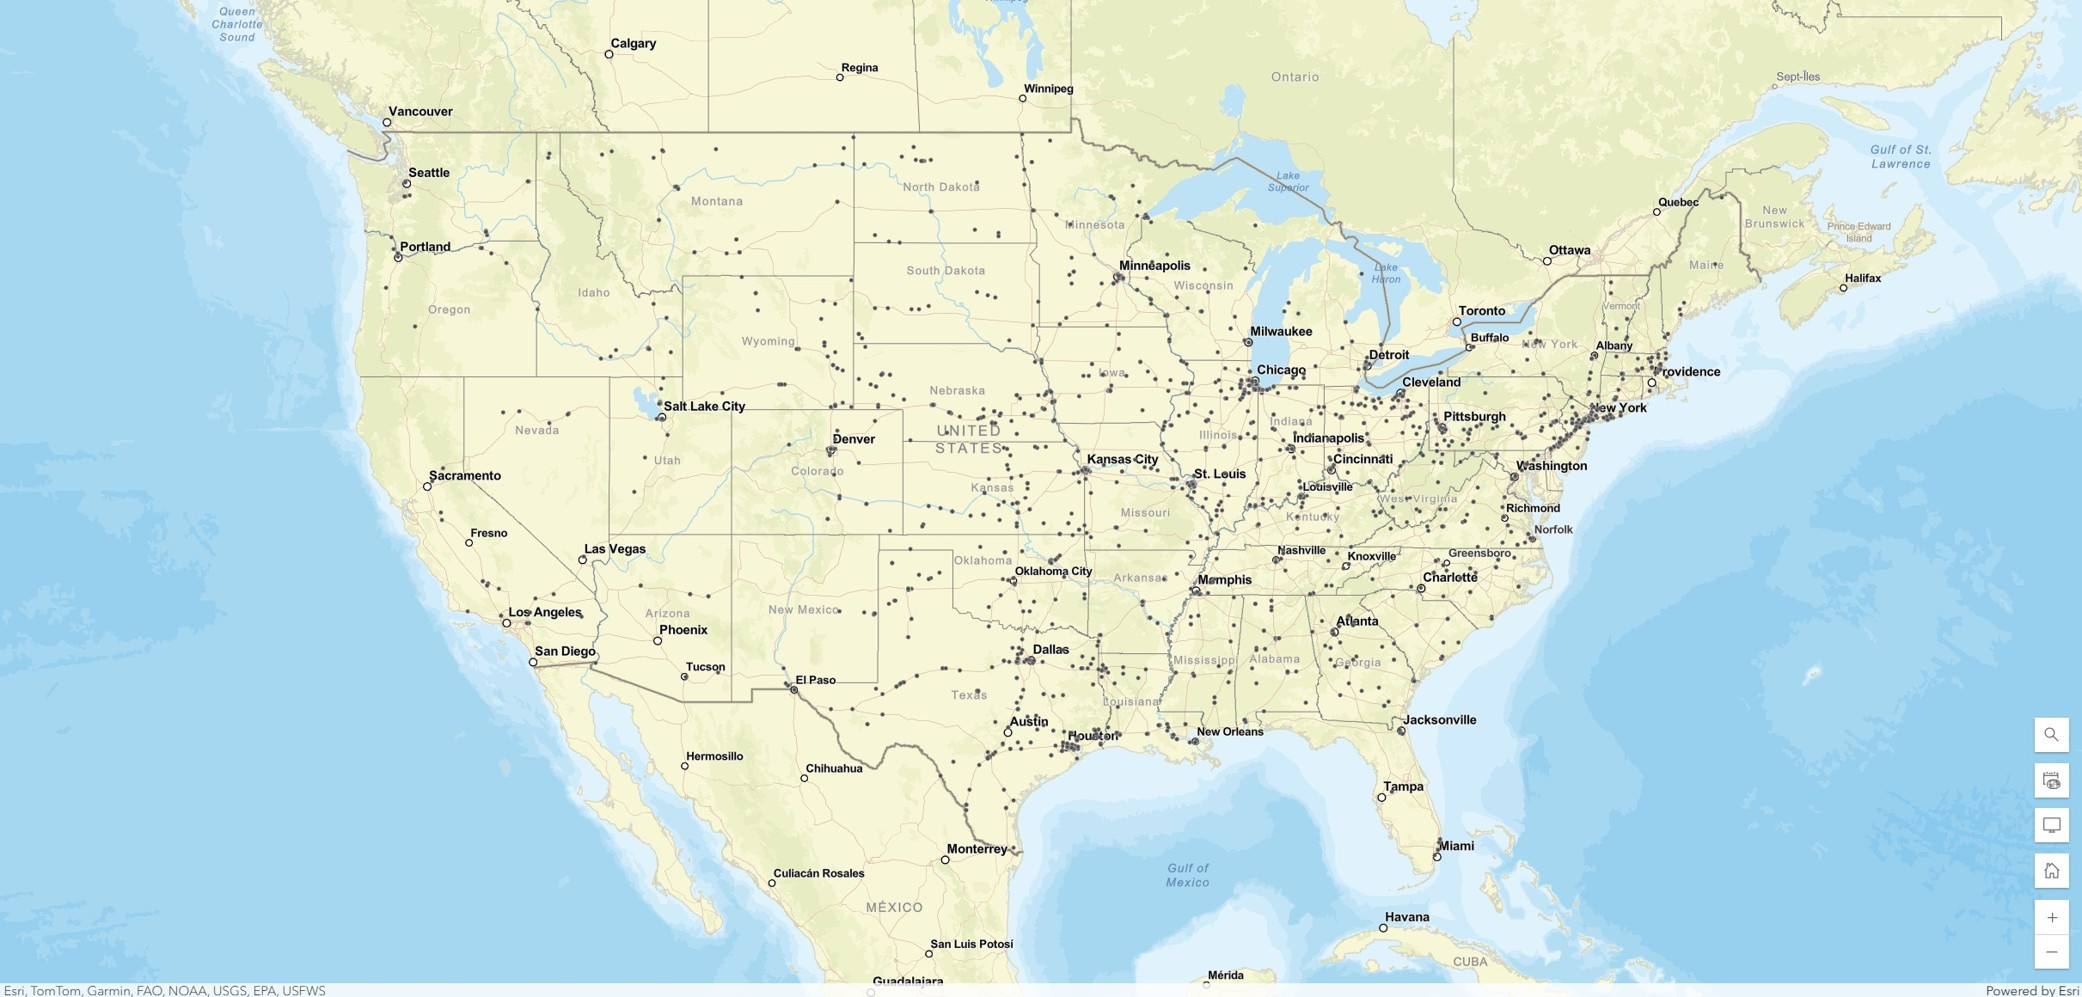

In [56]:
Image("images/US_Track-Related_Incidents.jpg")

<p>While 12°F temperature change track-related incidents have occurred all over the U.S. in the past decade, the majority occur on the Eastern half of the country.</p>

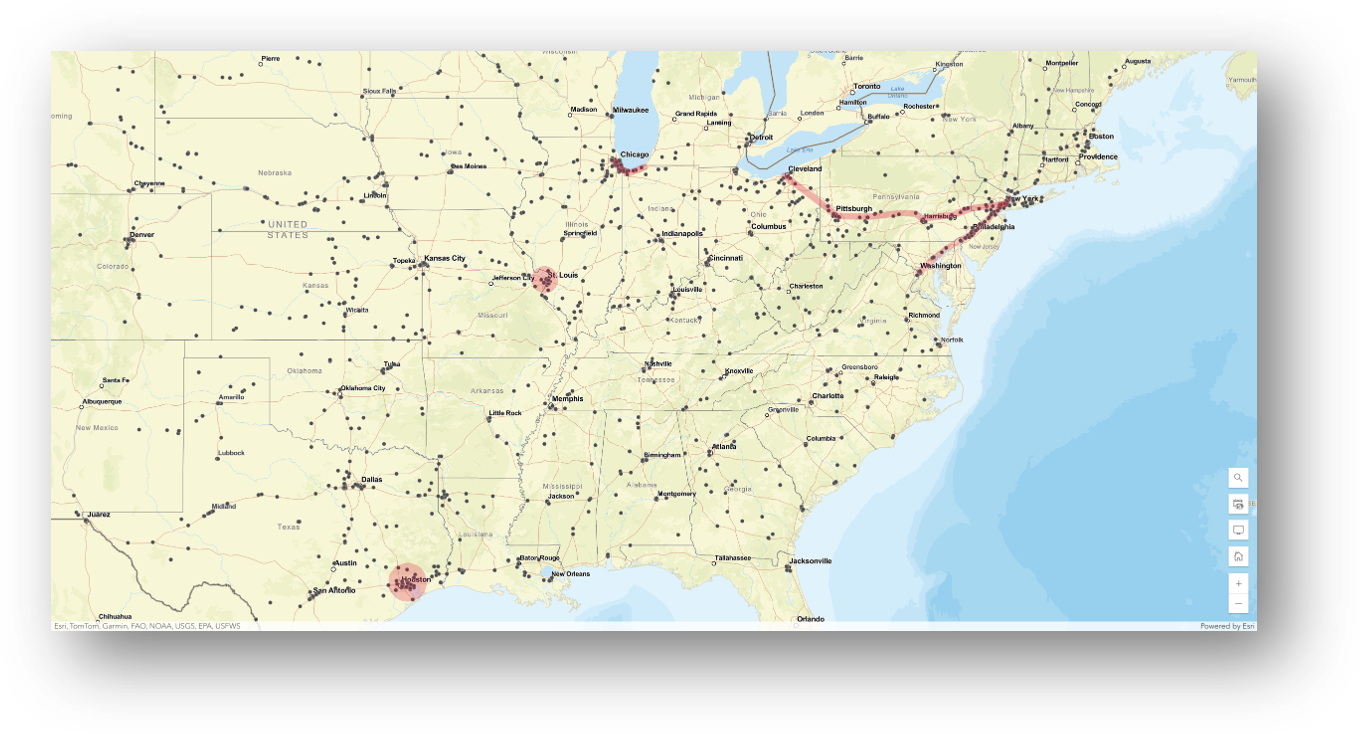

In [55]:
Image("images/Eastern_US_Track-Related_Incidents.png")

You can see by the groupings on the map that high-risk cities include Houston, St. Louis, Chicago, New York City, Philadelphia, and Washington DC. High-risk rail routes are from Cleveland to New York City to Washington DC.

## Conclusion

## References

<ul>
<li>Transportation, U. D. (n.d.). Transportation data: National Highway Traffic Safety Administration [Data set]. Retrieved October18, 2024, from https://data.transportation.gov/resource/85tf-2kj.json
</li>
<li>U.S. Department of Transportation, F.R. (2011). FRA Guide for Preparing Accident/Incident Reports. Retrieved October 18, 2024, from https://railroads.dot.gov/sites/fra.dot.gov/files/fra_net/18233/FRAGuideforPreparingAccIncReportspubMay2011.pdf
</li>
<li>Weather, V. C. (n.d.). Visual crossing web services timeline [Data set]. Retrieved October 20, 2024, from https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{start_date}/{end_date}
</li>
<li>Esri. (n.d.). ArcGIS Online. Environmental Systems Research Institute. https://www.arcgis.com
</li>
</ul>